In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from textblob import TextBlob
from wordcloud import WordCloud

from nltk.probability import FreqDist

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('all')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_p

True

***Question_1***

In [ ]:
print("\n=== Q1: Preprocessing & Tokenization ===")
paragraph = """Artificial Intelligence is my favorite topic. It is rapidly changing how humans interact with machines.
From self-driving cars to personalized recommendations, AI is everywhere. It mimics human intelligence and learns from data.
The applications of AI are vast and still expanding. Its evolution is shaping the future of technology."""

text_clean = re.sub(r'[^\w\s]', '', paragraph.lower())

words = word_tokenize(text_clean)
sentences = sent_tokenize(paragraph)

split_words = text_clean.split()
print("\nsplit() output:", split_words[:10])
print("word_tokenize() output:", words[:10])

stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

freq_dist = FreqDist(filtered_words)
print("\nWord Frequency (Top 5):", freq_dist.most_common(5))


=== Q1: Preprocessing & Tokenization ===

split() output: ['artificial', 'intelligence', 'is', 'my', 'favorite', 'topic', 'it', 'is', 'rapidly', 'changing']
word_tokenize() output: ['artificial', 'intelligence', 'is', 'my', 'favorite', 'topic', 'it', 'is', 'rapidly', 'changing']

Word Frequency (Top 5): [('intelligence', 2), ('ai', 2), ('artificial', 1), ('favorite', 1), ('topic', 1)]


***Question_2***

In [ ]:
print("\n=== Q2: Alpha Filtering, Stemming & Lemmatization ===")

alpha_words = re.findall(r'\b[a-zA-Z]+\b', text_clean)

filtered_alpha = [word for word in alpha_words if word not in stop_words]

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

stemmed = [stemmer.stem(word) for word in filtered_alpha]
lemmatized = [lemmatizer.lemmatize(word) for word in filtered_alpha]

print("\nOriginal:", filtered_alpha[:10])
print("Stemmed :", stemmed[:10])
print("Lemmatized:", lemmatized[:10])


=== Q2: Alpha Filtering, Stemming & Lemmatization ===

Original: ['artificial', 'intelligence', 'favorite', 'topic', 'rapidly', 'changing', 'humans', 'interact', 'machines', 'selfdriving']
Stemmed : ['artifici', 'intellig', 'favorit', 'topic', 'rapidli', 'chang', 'human', 'interact', 'machin', 'selfdriv']
Lemmatized: ['artificial', 'intelligence', 'favorite', 'topic', 'rapidly', 'changing', 'human', 'interact', 'machine', 'selfdriving']


***Question_3***

In [ ]:
print("\n=== Q3: BoW & TF-IDF ===")
texts = [
    "Battery life of this phone is amazing and lasts for two days.",
    "The camera quality is excellent, especially in low light conditions.",
    "Fast performance but heating issue while playing heavy games."
]

cv = CountVectorizer()
cv_matrix = cv.fit_transform(texts)
print("\nBoW Vocabulary:", cv.vocabulary_)

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(texts)
feature_names = tfidf.get_feature_names_out()

for i, row in enumerate(tfidf_matrix):
    row_arr = row.toarray().flatten()
    top3 = row_arr.argsort()[-3:][::-1]
    keywords = [(feature_names[i], row_arr[i]) for i in top3]
    print(f"\nText {i+1}:")
    for k, v in keywords:
        print(f"  {k}: {v:.4f}")


=== Q3: BoW & TF-IDF ===

BoW Vocabulary: {'battery': 2, 'life': 18, 'of': 21, 'this': 27, 'phone': 23, 'is': 15, 'amazing': 0, 'and': 1, 'lasts': 17, 'for': 10, 'two': 28, 'days': 6, 'the': 26, 'camera': 4, 'quality': 25, 'excellent': 8, 'especially': 7, 'in': 14, 'low': 20, 'light': 19, 'conditions': 5, 'fast': 9, 'performance': 22, 'but': 3, 'heating': 12, 'issue': 16, 'while': 29, 'playing': 24, 'heavy': 13, 'games': 11}

Text 1:
  two: 0.2939
  this: 0.2939
  life: 0.2939

Text 2:
  quality: 0.3231
  the: 0.3231
  light: 0.3231

Text 3:
  while: 0.3333
  playing: 0.3333
  issue: 0.3333


***Question_4***

In [ ]:
text_ai = """Artificial Intelligence enables machines to mimic human intelligence.
It is used in voice assistants, image recognition, and self-driving cars.
AI learns from data and improves its decision-making capabilities."""

text_blockchain = """Blockchain is a decentralized technology for secure digital transactions.
It ensures transparency and data integrity without needing a central authority.
It is widely used in cryptocurrencies and smart contracts."""

def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text.lower())        # lowercase + remove punctuation
    tokens = word_tokenize(text)                       # tokenize
    return tokens

tokens_ai = preprocess(text_ai)
tokens_blockchain = preprocess(text_blockchain)

set_ai = set(tokens_ai)
set_blockchain = set(tokens_blockchain)
jaccard_sim = len(set_ai & set_blockchain) / len(set_ai | set_blockchain)
print(f"Jaccard Similarity: {jaccard_sim:.4f}")

tfidf_vec = TfidfVectorizer()
tfidf_matrix = tfidf_vec.fit_transform([text_ai, text_blockchain])
cos_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
print(f"Cosine Similarity: {cos_sim:.4f}")

Jaccard Similarity: 0.1333
Cosine Similarity: 0.2025


***Question_5***

Review 1: The camera quality is outstanding and battery lasts long!
 - Polarity: 0.22, Subjectivity: 0.64
 - Sentiment: Positive

Review 2: Terrible customer service. I regret buying this.
 - Polarity: -1.00, Subjectivity: 1.00
 - Sentiment: Negative

Review 3: It's okay, not too good, not too bad.
 - Polarity: 0.17, Subjectivity: 0.59
 - Sentiment: Positive



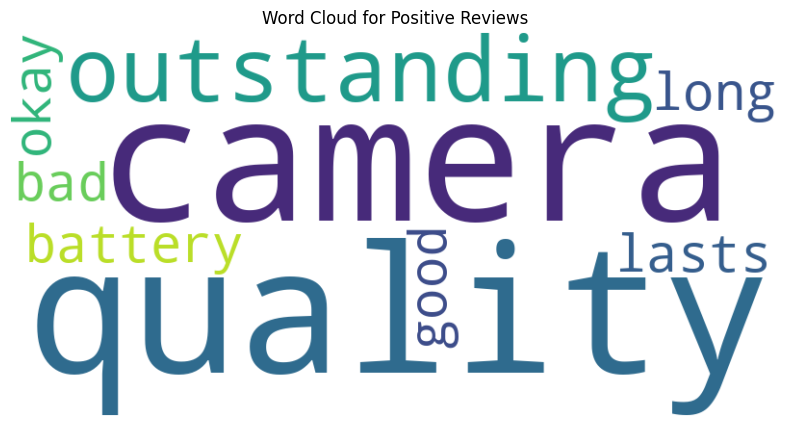

In [ ]:
reviews = [
    "The camera quality is outstanding and battery lasts long!",
    "Terrible customer service. I regret buying this.",
    "It's okay, not too good, not too bad."
]

for i, review in enumerate(reviews):
    blob = TextBlob(review)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    sentiment = "Positive" if polarity > 0 else "Negative" if polarity < 0 else "Neutral"

    print(f"Review {i+1}: {review}")
    print(f" - Polarity: {polarity:.2f}, Subjectivity: {subjectivity:.2f}")
    print(f" - Sentiment: {sentiment}\n")

positive_reviews = " ".join([review for review in reviews if TextBlob(review).sentiment.polarity > 0])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")
plt.show()

***Question_6***

In [ ]:
print("\n=== Q6: Text Generation with LSTM ===")
text_data = """
Technology continues to evolve rapidly, changing how we communicate, learn, and work.
From artificial intelligence to blockchain, every innovation impacts our daily lives.
Developers now build smart systems capable of understanding speech and making decisions.
Cloud computing allows data to be accessed from anywhere in the world.
These advancements offer convenience, efficiency, and scalability.
As machines get smarter, ethical considerations and responsible usage are crucial.
The future of technology holds possibilities we can't even imagine today.
"""

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text_data])
total_words = len(tokenizer.word_index) + 1
tokens = tokenizer.texts_to_sequences([text_data])[0]

input_seqs = []
for i in range(1, len(tokens)):
    ngram = tokens[:i+1]
    input_seqs.append(ngram)

max_len = max(len(x) for x in input_seqs)
input_seqs = pad_sequences(input_seqs, maxlen=max_len, padding='pre')
X = input_seqs[:, :-1]
y = to_categorical(input_seqs[:, -1], num_classes=total_words)

model = Sequential()
model.add(Embedding(total_words, 10, input_length=max_len - 1))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=0)

def generate(seed, words=15):
    for _ in range(words):
        seq = tokenizer.texts_to_sequences([seed])[0]
        seq = pad_sequences([seq], maxlen=max_len-1, padding='pre')
        pred = np.argmax(model.predict(seq, verbose=0), axis=-1)[0]
        output = ''
        for w, i in tokenizer.word_index.items():
            if i == pred:
                output = w
                break
        seed += ' ' + output
    return seed

print("\nGenerated 1:", generate("technology"))
print("Generated 2:", generate("cloud"))
print("Generated 3:", generate("developers"))


=== Q6: Text Generation with LSTM ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Generated 1: technology continues continues evolve evolve changing how we communicate learn learn work from artificial artificial blockchain
Generated 2: cloud continues evolve evolve evolve changing we communicate learn learn and work artificial artificial to blockchain
Generated 3: developers continues evolve evolve evolve changing we we learn learn and work artificial artificial to blockchain
